In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, roc_curve, auc, roc_auc_score
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import label_binarize
from ModelEvaluation import ModelEvaluation

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 250)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 250, 128)  │  3,840,000 │ input_layer[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 248, 128)  │     49,280 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 247, 128)  │     65,664 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 246, 128)  │     82,048 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 128)       │          0 │ conv1d[0][0]      │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 128)       │          0 │ conv1d_1[0][0]    │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 128)       │          0 │ conv1d_2[0][0]    │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 384)       │          0 │ global_max_pooli… │
│ (Concatenate)       │                   │            │ global_max_pooli… │
│                     │                   │            │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 384)       │          0 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │     49,280 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 3)         │        387 │ dense[0][0]       │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 4,086,659 (15.59 MB)

 Trainable params: 4,086,659 (15.59 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
196/196 ━━━━━━━━━━━━━━━━━━━━ 34s 74ms/step - accuracy: 0.4166 - loss: 1.0598 - val_accuracy: 0.6146 - val_loss: 0.8174
Epoch 2/20
196/196 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.6969 - loss: 0.7163 - val_accuracy: 0.6309 - val_loss: 0.7988
Epoch 3/20
196/196 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.8238 - loss: 0.4710 - val_accuracy: 0.6218 - val_loss: 0.9300
Epoch 4/20
196/196 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.8999 - loss: 0.2788 - val_accuracy: 0.6087 - val_loss: 1.1198
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
MODEL EVALUATION METRICS
Accuracy:  0.6459
Precision: 0.6493
Recall:    0.6459
F1-Score:  0.6472

CLASSIFICATION REPORT
              precision    recall  f1-score   support

           0       0.74      0.69      0.71      1236
           1       0.55      0.57      0.56      1217
           2       0.66      0.68      0.67      1227

    accuracy                           0.65      3680
   macro avg       0.65      0.65      0.65      3

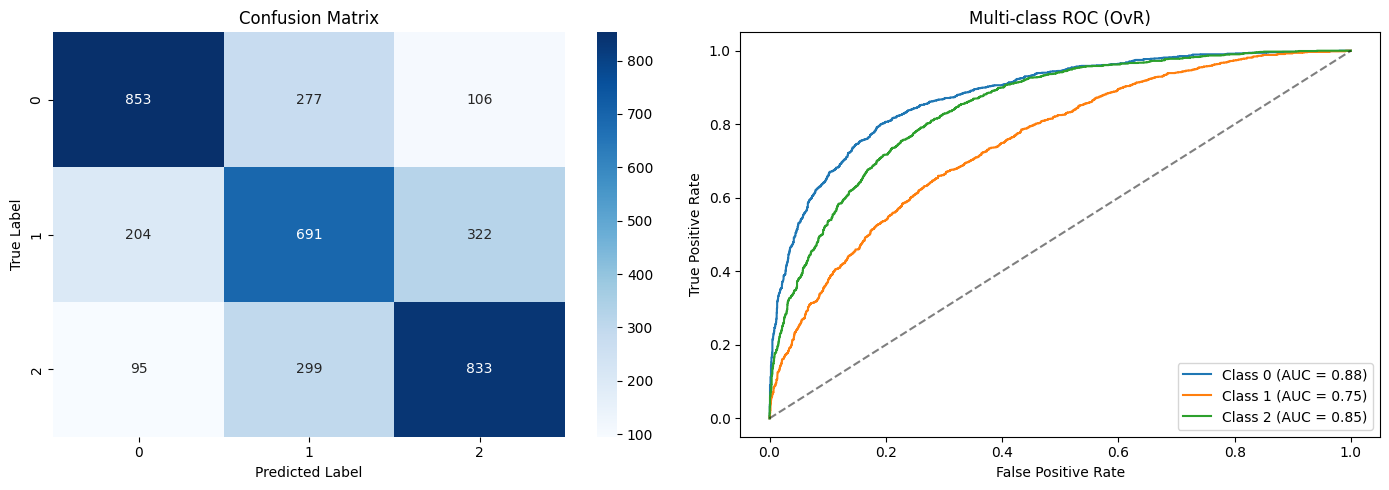

In [2]:
# 0. without_stop_word
DATA_PATH = "/content/amazon_user_reviews_text_sentiment.parquet"

# SETTINGS (instead of argparse)
TEXT_COL = "text_cleaned"
LABEL_COL = "sentiment"

VOCAB_SIZE = 30000
MAX_LEN = 250
EMB_DIM = 128

FILTERS = 128
KERNEL_SIZES = [3, 4, 5]
DROPOUT = 0.5
DENSE_UNITS = 128

EPOCHS = 20
BATCH_SIZE = 64


# LOAD DATA
df = pd.read_parquet(DATA_PATH)

texts = df[TEXT_COL].astype(str).tolist()
y_raw = df[LABEL_COL].astype(int).to_numpy()


# Label mapping
unique = np.sort(np.unique(y_raw))
label_map = {int(v): i for i, v in enumerate(unique)}
y = np.array([label_map[int(v)] for v in y_raw])


# Split
X_train_texts, X_test_texts, y_train, y_test = train_test_split(
    texts, y, test_size=0.2, random_state=42, stratify=y
)


# TOKENIZE
tok = Tokenizer(num_words=VOCAB_SIZE, oov_token="<OOV>")
tok.fit_on_texts(X_train_texts)

X_train = pad_sequences(tok.texts_to_sequences(X_train_texts), maxlen=MAX_LEN, padding="post")
X_test  = pad_sequences(tok.texts_to_sequences(X_test_texts),  maxlen=MAX_LEN, padding="post")


# BUILD CNN
inputs = tf.keras.Input(shape=(MAX_LEN,))
x = layers.Embedding(VOCAB_SIZE, EMB_DIM)(inputs)

convs = []
for k in KERNEL_SIZES:
    c = layers.Conv1D(FILTERS, k, activation="relu")(x)
    c = layers.GlobalMaxPooling1D()(c)
    convs.append(c)

x = layers.Concatenate()(convs)
x = layers.Dropout(DROPOUT)(x)
x = layers.Dense(DENSE_UNITS, activation="relu")(x)
outputs = layers.Dense(3, activation="softmax")(x)

model = tf.keras.Model(inputs, outputs)

model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()


# TRAIN
history = model.fit(
    X_train, y_train,
    validation_split=0.15,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=2, restore_best_weights=True)]
)


# EVALUATE
probs = model.predict(X_test)
pred = np.argmax(probs, axis=1)

evaluator = ModelEvaluation()
evaluator.run_pipeline(y_test, pred, probs)


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 250)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, 250, 128)  │  3,840,000 │ input_layer_1[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3 (Conv1D)   │ (None, 248, 128)  │     49,280 │ embedding_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_4 (Conv1D)   │ (None, 247, 128)  │     65,664 │ embedding_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_5 (Conv1D)   │ (None, 246, 128)  │     82,048 │ embedding_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 128)       │          0 │ conv1d_3[0][0]    │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 128)       │          0 │ conv1d_4[0][0]    │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 128)       │          0 │ conv1d_5[0][0]    │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 384)       │          0 │ global_max_pooli… │
│ (Concatenate)       │                   │            │ global_max_pooli… │
│                     │                   │            │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 384)       │          0 │ concatenate_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 128)       │     49,280 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 3)         │        387 │ dense_2[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 4,086,659 (15.59 MB)

 Trainable params: 4,086,659 (15.59 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
393/393 ━━━━━━━━━━━━━━━━━━━━ 15s 29ms/step - accuracy: 0.4711 - loss: 0.9894 - val_accuracy: 0.6285 - val_loss: 0.7924
Epoch 2/20
393/393 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - accuracy: 0.7099 - loss: 0.6746 - val_accuracy: 0.6355 - val_loss: 0.7954
Epoch 3/20
393/393 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.8144 - loss: 0.4751 - val_accuracy: 0.6264 - val_loss: 0.8888
231/231 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
MODEL EVALUATION METRICS
Accuracy:  0.6460
Precision: 0.6434
Recall:    0.6460
F1-Score:  0.6353

CLASSIFICATION REPORT
              precision    recall  f1-score   support

           0       0.71      0.74      0.72      2474
           1       0.61      0.41      0.49      2439
           2       0.62      0.78      0.69      2475

    accuracy                           0.65      7388
   macro avg       0.64      0.64      0.63      7388
weighted avg       0.64      0.65      0.64      7388

ROC=AUC REPORT
AUC score: 0.8271522844597178


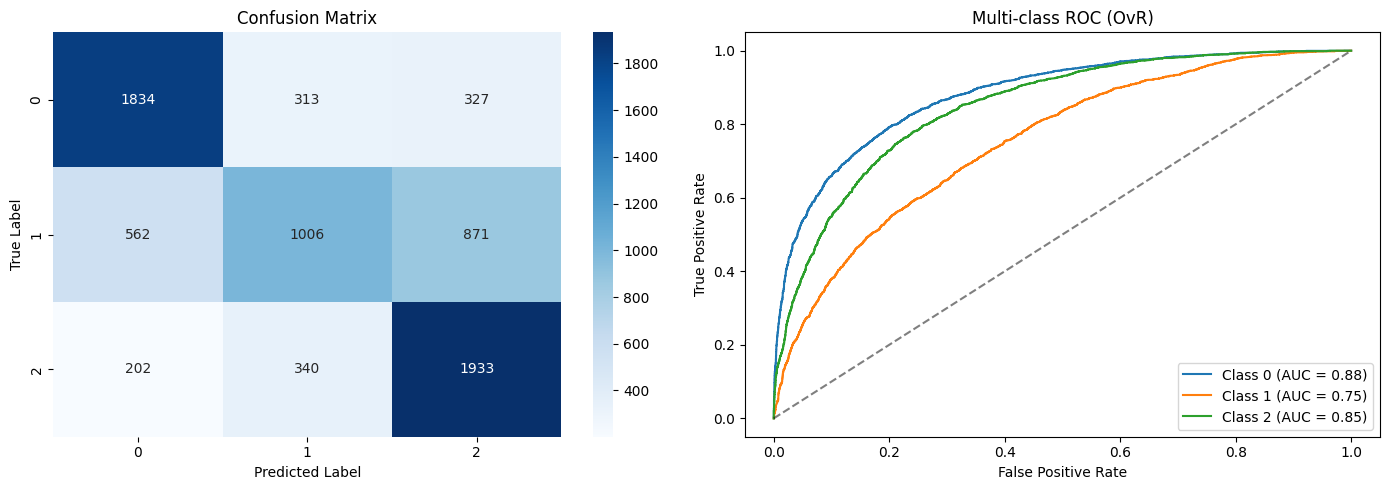

In [3]:
# 0.2 without_stop_word extended
DATA_PATH = "/content/amazon_user_reviews_text_sentiment_extended.parquet"

# SETTINGS (instead of argparse)
TEXT_COL = "text_cleaned"
LABEL_COL = "sentiment"

VOCAB_SIZE = 30000
MAX_LEN = 250
EMB_DIM = 128

FILTERS = 128
KERNEL_SIZES = [3, 4, 5]
DROPOUT = 0.5
DENSE_UNITS = 128

EPOCHS = 20
BATCH_SIZE = 64


# LOAD DATA
df = pd.read_parquet(DATA_PATH)

texts = df[TEXT_COL].astype(str).tolist()
y_raw = df[LABEL_COL].astype(int).to_numpy()


# Label mapping
unique = np.sort(np.unique(y_raw))
label_map = {int(v): i for i, v in enumerate(unique)}
y = np.array([label_map[int(v)] for v in y_raw])


# Split
X_train_texts, X_test_texts, y_train, y_test = train_test_split(
    texts, y, test_size=0.2, random_state=42, stratify=y
)


# TOKENIZE
tok = Tokenizer(num_words=VOCAB_SIZE, oov_token="<OOV>")
tok.fit_on_texts(X_train_texts)

X_train = pad_sequences(tok.texts_to_sequences(X_train_texts), maxlen=MAX_LEN, padding="post")
X_test  = pad_sequences(tok.texts_to_sequences(X_test_texts),  maxlen=MAX_LEN, padding="post")


# BUILD CNN
inputs = tf.keras.Input(shape=(MAX_LEN,))
x = layers.Embedding(VOCAB_SIZE, EMB_DIM)(inputs)

convs = []
for k in KERNEL_SIZES:
    c = layers.Conv1D(FILTERS, k, activation="relu")(x)
    c = layers.GlobalMaxPooling1D()(c)
    convs.append(c)

x = layers.Concatenate()(convs)
x = layers.Dropout(DROPOUT)(x)
x = layers.Dense(DENSE_UNITS, activation="relu")(x)
outputs = layers.Dense(3, activation="softmax")(x)

model = tf.keras.Model(inputs, outputs)

model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()


# TRAIN
history = model.fit(
    X_train, y_train,
    validation_split=0.15,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=2, restore_best_weights=True)]
)


# EVALUATE
probs = model.predict(X_test)
pred = np.argmax(probs, axis=1)

evaluator = ModelEvaluation()
evaluator.run_pipeline(y_test, pred, probs)


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 250)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_2         │ (None, 250, 128)  │  3,840,000 │ input_layer_2[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_6 (Conv1D)   │ (None, 248, 128)  │     49,280 │ embedding_2[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_7 (Conv1D)   │ (None, 247, 128)  │     65,664 │ embedding_2[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_8 (Conv1D)   │ (None, 246, 128)  │     82,048 │ embedding_2[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 128)       │          0 │ conv1d_6[0][0]    │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 128)       │          0 │ conv1d_7[0][0]    │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 128)       │          0 │ conv1d_8[0][0]    │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, 384)       │          0 │ global_max_pooli… │
│ (Concatenate)       │                   │            │ global_max_pooli… │
│                     │                   │            │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 384)       │          0 │ concatenate_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 128)       │     49,280 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 3)         │        387 │ dense_4[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 4,086,659 (15.59 MB)

 Trainable params: 4,086,659 (15.59 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
196/196 ━━━━━━━━━━━━━━━━━━━━ 9s 27ms/step - accuracy: 0.4342 - loss: 1.0447 - val_accuracy: 0.6553 - val_loss: 0.7710
Epoch 2/20
196/196 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.6955 - loss: 0.6892 - val_accuracy: 0.6893 - val_loss: 0.7097
Epoch 3/20
196/196 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8099 - loss: 0.4755 - val_accuracy: 0.6762 - val_loss: 0.7750
Epoch 4/20
196/196 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.8972 - loss: 0.2830 - val_accuracy: 0.6698 - val_loss: 0.8992
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
MODEL EVALUATION METRICS
Accuracy:  0.6937
Precision: 0.6893
Recall:    0.6937
F1-Score:  0.6899

CLASSIFICATION REPORT
              precision    recall  f1-score   support

           0       0.76      0.81      0.79      1236
           1       0.62      0.54      0.58      1217
           2       0.68      0.73      0.71      1227

    accuracy                           0.69      3680
   macro avg       0.69      0.69      0.69      36

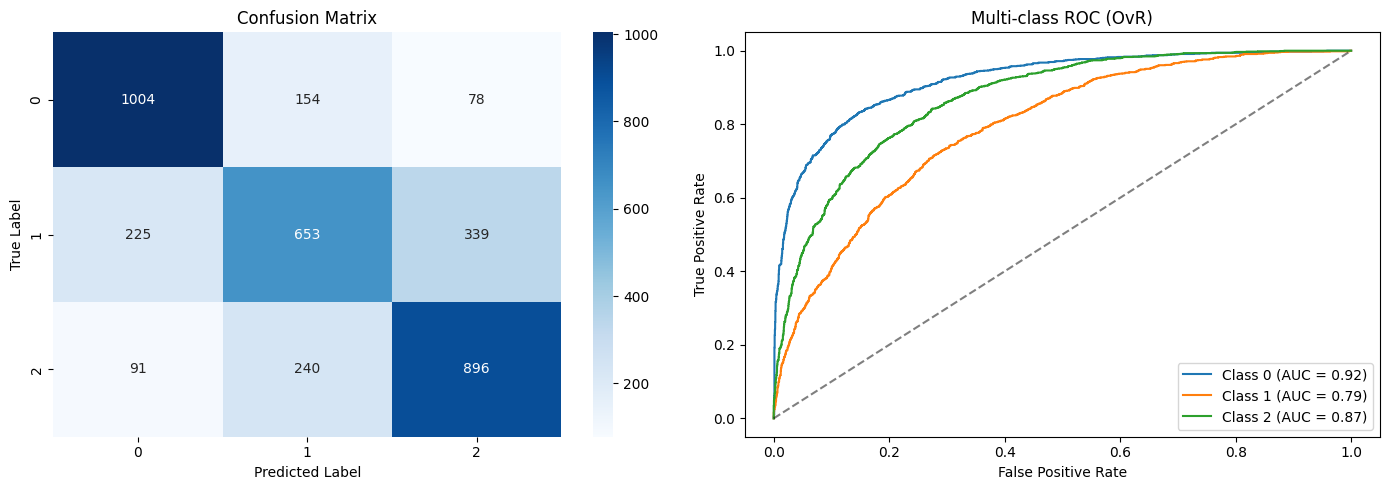

In [4]:
# 1. with_stop_word
DATA_PATH = "amazon_user_reviews_text_sentiment_with_sw.parquet"

# SETTINGS (instead of argparse)
TEXT_COL = "original_text"
LABEL_COL = "sentiment"

VOCAB_SIZE = 30000
MAX_LEN = 250
EMB_DIM = 128

FILTERS = 128
KERNEL_SIZES = [3, 4, 5]
DROPOUT = 0.5
DENSE_UNITS = 128

EPOCHS = 20
BATCH_SIZE = 64


# LOAD DATA
df = pd.read_parquet(DATA_PATH)

texts = df[TEXT_COL].astype(str).tolist()
y_raw = df[LABEL_COL].astype(int).to_numpy()


# Label mapping
unique = np.sort(np.unique(y_raw))
label_map = {int(v): i for i, v in enumerate(unique)}
y = np.array([label_map[int(v)] for v in y_raw])


# Split
X_train_texts, X_test_texts, y_train, y_test = train_test_split(
    texts, y, test_size=0.2, random_state=42, stratify=y
)


# TOKENIZE
tok = Tokenizer(num_words=VOCAB_SIZE, oov_token="<OOV>")
tok.fit_on_texts(X_train_texts)

X_train = pad_sequences(tok.texts_to_sequences(X_train_texts), maxlen=MAX_LEN, padding="post")
X_test  = pad_sequences(tok.texts_to_sequences(X_test_texts),  maxlen=MAX_LEN, padding="post")


# BUILD CNN
inputs = tf.keras.Input(shape=(MAX_LEN,))
x = layers.Embedding(VOCAB_SIZE, EMB_DIM)(inputs)

convs = []
for k in KERNEL_SIZES:
    c = layers.Conv1D(FILTERS, k, activation="relu")(x)
    c = layers.GlobalMaxPooling1D()(c)
    convs.append(c)

x = layers.Concatenate()(convs)
x = layers.Dropout(DROPOUT)(x)
x = layers.Dense(DENSE_UNITS, activation="relu")(x)
outputs = layers.Dense(3, activation="softmax")(x)

model = tf.keras.Model(inputs, outputs)

model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()


# TRAIN
history = model.fit(
    X_train, y_train,
    validation_split=0.15,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=2, restore_best_weights=True)]
)


# EVALUATE
probs = model.predict(X_test)
pred = np.argmax(probs, axis=1)

evaluator = ModelEvaluation()
evaluator.run_pipeline(y_test, pred, probs)


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 250)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_3         │ (None, 250, 128)  │  3,840,000 │ input_layer_3[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_9 (Conv1D)   │ (None, 248, 128)  │     49,280 │ embedding_3[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_10 (Conv1D)  │ (None, 247, 128)  │     65,664 │ embedding_3[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_11 (Conv1D)  │ (None, 246, 128)  │     82,048 │ embedding_3[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 128)       │          0 │ conv1d_9[0][0]    │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 128)       │          0 │ conv1d_10[0][0]   │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 128)       │          0 │ conv1d_11[0][0]   │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_3       │ (None, 384)       │          0 │ global_max_pooli… │
│ (Concatenate)       │                   │            │ global_max_pooli… │
│                     │                   │            │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 384)       │          0 │ concatenate_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 128)       │     49,280 │ dropout_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 3)         │        387 │ dense_6[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 4,086,659 (15.59 MB)

 Trainable params: 4,086,659 (15.59 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
196/196 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - accuracy: 0.4308 - loss: 1.0486 - val_accuracy: 0.6549 - val_loss: 0.7709
Epoch 2/20
196/196 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.6894 - loss: 0.6991 - val_accuracy: 0.6753 - val_loss: 0.7284
Epoch 3/20
196/196 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8161 - loss: 0.4751 - val_accuracy: 0.6762 - val_loss: 0.7775
Epoch 4/20
196/196 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9008 - loss: 0.2825 - val_accuracy: 0.6590 - val_loss: 0.9134
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
MODEL EVALUATION METRICS
Accuracy:  0.6889
Precision: 0.7113
Recall:    0.6889
F1-Score:  0.6927

CLASSIFICATION REPORT
              precision    recall  f1-score   support

           0       0.82      0.74      0.78      1236
           1       0.55      0.72      0.63      1217
           2       0.76      0.60      0.67      1227

    accuracy                           0.69      3680
   macro avg       0.71      0.69      0.69      36

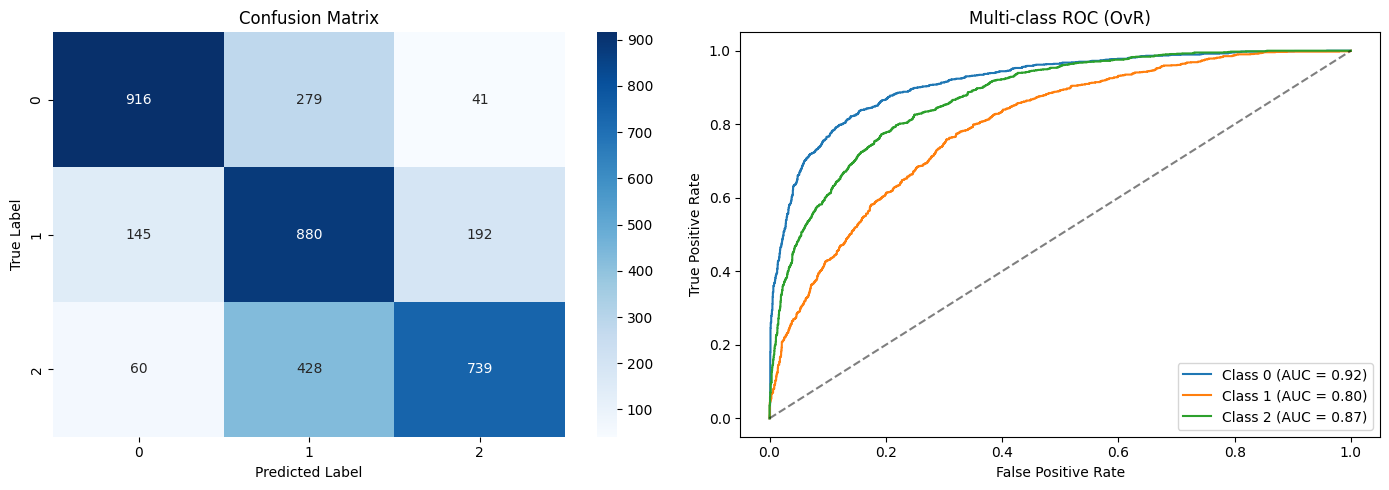

In [5]:
# 2. with_stop_word + feature
DATA_PATH = "amazon_user_reviews_textANDfeature_sentiment_with_sw.parquet"

# SETTINGS (instead of argparse)
TEXT_COL = "original_text"
LABEL_COL = "sentiment"

VOCAB_SIZE = 30000
MAX_LEN = 250
EMB_DIM = 128

FILTERS = 128
KERNEL_SIZES = [3, 4, 5]
DROPOUT = 0.5
DENSE_UNITS = 128

EPOCHS = 20
BATCH_SIZE = 64


# LOAD DATA
df = pd.read_parquet(DATA_PATH)

texts = df[TEXT_COL].astype(str).tolist()
y_raw = df[LABEL_COL].astype(int).to_numpy()


# Label mapping
unique = np.sort(np.unique(y_raw))
label_map = {int(v): i for i, v in enumerate(unique)}
y = np.array([label_map[int(v)] for v in y_raw])


# Split
X_train_texts, X_test_texts, y_train, y_test = train_test_split(
    texts, y, test_size=0.2, random_state=42, stratify=y
)


# TOKENIZE
tok = Tokenizer(num_words=VOCAB_SIZE, oov_token="<OOV>")
tok.fit_on_texts(X_train_texts)

X_train = pad_sequences(tok.texts_to_sequences(X_train_texts), maxlen=MAX_LEN, padding="post")
X_test  = pad_sequences(tok.texts_to_sequences(X_test_texts),  maxlen=MAX_LEN, padding="post")


# BUILD CNN
inputs = tf.keras.Input(shape=(MAX_LEN,))
x = layers.Embedding(VOCAB_SIZE, EMB_DIM)(inputs)

convs = []
for k in KERNEL_SIZES:
    c = layers.Conv1D(FILTERS, k, activation="relu")(x)
    c = layers.GlobalMaxPooling1D()(c)
    convs.append(c)

x = layers.Concatenate()(convs)
x = layers.Dropout(DROPOUT)(x)
x = layers.Dense(DENSE_UNITS, activation="relu")(x)
outputs = layers.Dense(3, activation="softmax")(x)

model = tf.keras.Model(inputs, outputs)

model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()


# TRAIN
history = model.fit(
    X_train, y_train,
    validation_split=0.15,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=2, restore_best_weights=True)]
)


# EVALUATE
probs = model.predict(X_test)
pred = np.argmax(probs, axis=1)

evaluator = ModelEvaluation()
evaluator.run_pipeline(y_test, pred, probs)


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 250)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_4         │ (None, 250, 128)  │  3,840,000 │ input_layer_4[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_12 (Conv1D)  │ (None, 248, 128)  │     49,280 │ embedding_4[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_13 (Conv1D)  │ (None, 247, 128)  │     65,664 │ embedding_4[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_14 (Conv1D)  │ (None, 246, 128)  │     82,048 │ embedding_4[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 128)       │          0 │ conv1d_12[0][0]   │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 128)       │          0 │ conv1d_13[0][0]   │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 128)       │          0 │ conv1d_14[0][0]   │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_4       │ (None, 384)       │          0 │ global_max_pooli… │
│ (Concatenate)       │                   │            │ global_max_pooli… │
│                     │                   │            │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 384)       │          0 │ concatenate_4[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 128)       │     49,280 │ dropout_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_9 (Dense)     │ (None, 3)         │        387 │ dense_8[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 4,086,659 (15.59 MB)

 Trainable params: 4,086,659 (15.59 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
393/393 ━━━━━━━━━━━━━━━━━━━━ 12s 21ms/step - accuracy: 0.4905 - loss: 0.9688 - val_accuracy: 0.6862 - val_loss: 0.7217
Epoch 2/20
393/393 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.7245 - loss: 0.6363 - val_accuracy: 0.6813 - val_loss: 0.7105
Epoch 3/20
393/393 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.8195 - loss: 0.4598 - val_accuracy: 0.6752 - val_loss: 0.7574
Epoch 4/20
393/393 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.8874 - loss: 0.3032 - val_accuracy: 0.6625 - val_loss: 0.9370
231/231 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
MODEL EVALUATION METRICS
Accuracy:  0.6867
Precision: 0.6863
Recall:    0.6867
F1-Score:  0.6806

CLASSIFICATION REPORT
              precision    recall  f1-score   support

           0       0.79      0.77      0.78      2474
           1       0.62      0.48      0.54      2439
           2       0.64      0.80      0.72      2475

    accuracy                           0.69      7388
   macro avg       0.69      0.69      0.68      7

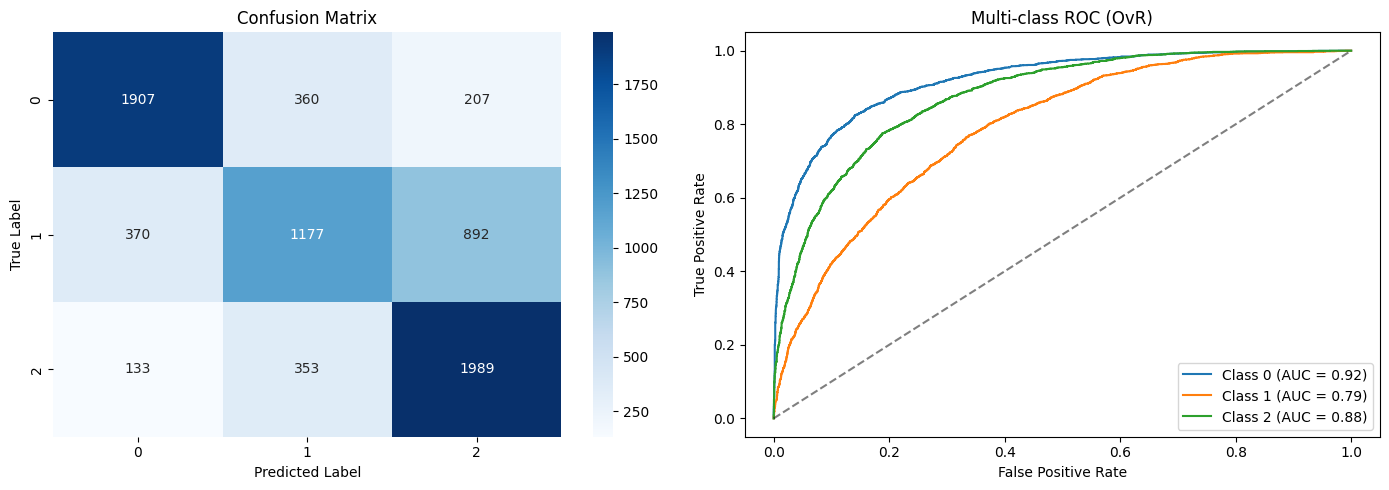

In [6]:
# 1.2. with_stop_word + feature extended
DATA_PATH = "amazon_user_reviews_text_sentiment_with_sw_extended.parquet"

# SETTINGS (instead of argparse)
TEXT_COL = "original_text"
LABEL_COL = "sentiment"

VOCAB_SIZE = 30000
MAX_LEN = 250
EMB_DIM = 128

FILTERS = 128
KERNEL_SIZES = [3, 4, 5]
DROPOUT = 0.5
DENSE_UNITS = 128

EPOCHS = 20
BATCH_SIZE = 64


# LOAD DATA
df = pd.read_parquet(DATA_PATH)

texts = df[TEXT_COL].astype(str).tolist()
y_raw = df[LABEL_COL].astype(int).to_numpy()


# Label mapping
unique = np.sort(np.unique(y_raw))
label_map = {int(v): i for i, v in enumerate(unique)}
y = np.array([label_map[int(v)] for v in y_raw])


# Split
X_train_texts, X_test_texts, y_train, y_test = train_test_split(
    texts, y, test_size=0.2, random_state=42, stratify=y
)


# TOKENIZE
tok = Tokenizer(num_words=VOCAB_SIZE, oov_token="<OOV>")
tok.fit_on_texts(X_train_texts)

X_train = pad_sequences(tok.texts_to_sequences(X_train_texts), maxlen=MAX_LEN, padding="post")
X_test  = pad_sequences(tok.texts_to_sequences(X_test_texts),  maxlen=MAX_LEN, padding="post")


# BUILD CNN
inputs = tf.keras.Input(shape=(MAX_LEN,))
x = layers.Embedding(VOCAB_SIZE, EMB_DIM)(inputs)

convs = []
for k in KERNEL_SIZES:
    c = layers.Conv1D(FILTERS, k, activation="relu")(x)
    c = layers.GlobalMaxPooling1D()(c)
    convs.append(c)

x = layers.Concatenate()(convs)
x = layers.Dropout(DROPOUT)(x)
x = layers.Dense(DENSE_UNITS, activation="relu")(x)
outputs = layers.Dense(3, activation="softmax")(x)

model = tf.keras.Model(inputs, outputs)

model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()


# TRAIN
history = model.fit(
    X_train, y_train,
    validation_split=0.15,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=2, restore_best_weights=True)]
)


# EVALUATE
probs = model.predict(X_test)
pred = np.argmax(probs, axis=1)

evaluator = ModelEvaluation()
evaluator.run_pipeline(y_test, pred, probs)


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (None, 250)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_5         │ (None, 250, 128)  │  3,840,000 │ input_layer_5[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_15 (Conv1D)  │ (None, 248, 128)  │     49,280 │ embedding_5[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_16 (Conv1D)  │ (None, 247, 128)  │     65,664 │ embedding_5[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_17 (Conv1D)  │ (None, 246, 128)  │     82,048 │ embedding_5[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 128)       │          0 │ conv1d_15[0][0]   │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 128)       │          0 │ conv1d_16[0][0]   │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 128)       │          0 │ conv1d_17[0][0]   │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_5       │ (None, 384)       │          0 │ global_max_pooli… │
│ (Concatenate)       │                   │            │ global_max_pooli… │
│                     │                   │            │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 384)       │          0 │ concatenate_5[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_10 (Dense)    │ (None, 128)       │     49,280 │ dropout_5[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_11 (Dense)    │ (None, 3)         │        387 │ dense_10[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 4,086,659 (15.59 MB)

 Trainable params: 4,086,659 (15.59 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
393/393 ━━━━━━━━━━━━━━━━━━━━ 12s 19ms/step - accuracy: 0.4970 - loss: 0.9640 - val_accuracy: 0.6734 - val_loss: 0.7230
Epoch 2/20
393/393 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.7233 - loss: 0.6357 - val_accuracy: 0.6808 - val_loss: 0.7151
Epoch 3/20
393/393 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.8255 - loss: 0.4427 - val_accuracy: 0.6677 - val_loss: 0.8139
Epoch 4/20
393/393 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.8889 - loss: 0.2997 - val_accuracy: 0.6562 - val_loss: 0.9555
231/231 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
MODEL EVALUATION METRICS
Accuracy:  0.6950
Precision: 0.6937
Recall:    0.6950
F1-Score:  0.6916

CLASSIFICATION REPORT
              precision    recall  f1-score   support

           0       0.78      0.77      0.78      2474
           1       0.63      0.53      0.58      2439
           2       0.67      0.78      0.72      2475

    accuracy                           0.70      7388
   macro avg       0.69      0.69      0.69      7

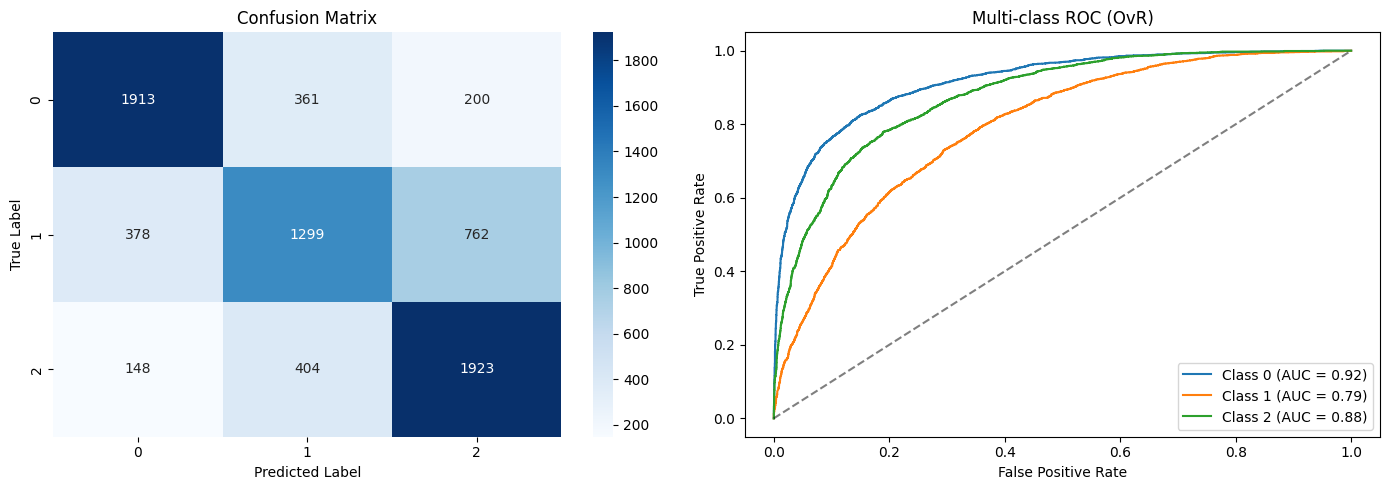

In [7]:
# 2.2. with_stop_word + feature extended
DATA_PATH = "amazon_user_reviews_textANDfeature_sentiment_with_sw_extended.parquet"

# SETTINGS (instead of argparse)
TEXT_COL = "original_text"
LABEL_COL = "sentiment"

VOCAB_SIZE = 30000
MAX_LEN = 250
EMB_DIM = 128

FILTERS = 128
KERNEL_SIZES = [3, 4, 5]
DROPOUT = 0.5
DENSE_UNITS = 128

EPOCHS = 20
BATCH_SIZE = 64


# LOAD DATA
df = pd.read_parquet(DATA_PATH)

texts = df[TEXT_COL].astype(str).tolist()
y_raw = df[LABEL_COL].astype(int).to_numpy()


# Label mapping
unique = np.sort(np.unique(y_raw))
label_map = {int(v): i for i, v in enumerate(unique)}
y = np.array([label_map[int(v)] for v in y_raw])


# Split
X_train_texts, X_test_texts, y_train, y_test = train_test_split(
    texts, y, test_size=0.2, random_state=42, stratify=y
)


# TOKENIZE
tok = Tokenizer(num_words=VOCAB_SIZE, oov_token="<OOV>")
tok.fit_on_texts(X_train_texts)

X_train = pad_sequences(tok.texts_to_sequences(X_train_texts), maxlen=MAX_LEN, padding="post")
X_test  = pad_sequences(tok.texts_to_sequences(X_test_texts),  maxlen=MAX_LEN, padding="post")


# BUILD CNN
inputs = tf.keras.Input(shape=(MAX_LEN,))
x = layers.Embedding(VOCAB_SIZE, EMB_DIM)(inputs)

convs = []
for k in KERNEL_SIZES:
    c = layers.Conv1D(FILTERS, k, activation="relu")(x)
    c = layers.GlobalMaxPooling1D()(c)
    convs.append(c)

x = layers.Concatenate()(convs)
x = layers.Dropout(DROPOUT)(x)
x = layers.Dense(DENSE_UNITS, activation="relu")(x)
outputs = layers.Dense(3, activation="softmax")(x)

model = tf.keras.Model(inputs, outputs)

model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()


# TRAIN
history = model.fit(
    X_train, y_train,
    validation_split=0.15,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=2, restore_best_weights=True)]
)


# EVALUATE
probs = model.predict(X_test)
pred = np.argmax(probs, axis=1)

evaluator = ModelEvaluation()
evaluator.run_pipeline(y_test, pred, probs)


In [8]:
import json

# model.save("textcnn_model.keras")

# with open("tokenizer.json", "w") as f:
    # f.write(tok.to_json())

# with open("label_map.json", "w") as f:
    # json.dump(label_map, f)